In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import os
import kagglehub
from xgboost import XGBClassifier

In [2]:
!pip install kagglehub pandas
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
import os
import kagglehub
# Download dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

dataset_files = os.listdir(path)
print("Dataset files:", dataset_files)

# Load CSV file into DataFrame
csv_file = [f for f in dataset_files if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

Dataset files: ['creditcard.csv']


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [4]:
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 1081


In [5]:
# Remove duplicate rows
df_cleaned = df.drop_duplicates()
print(f"Data after removing duplicates: {df_cleaned.shape[0]} rows")

Data after removing duplicates: 283726 rows


In [6]:
duplicates = df_cleaned[df_cleaned.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


In [ ]:
df_cleaned.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


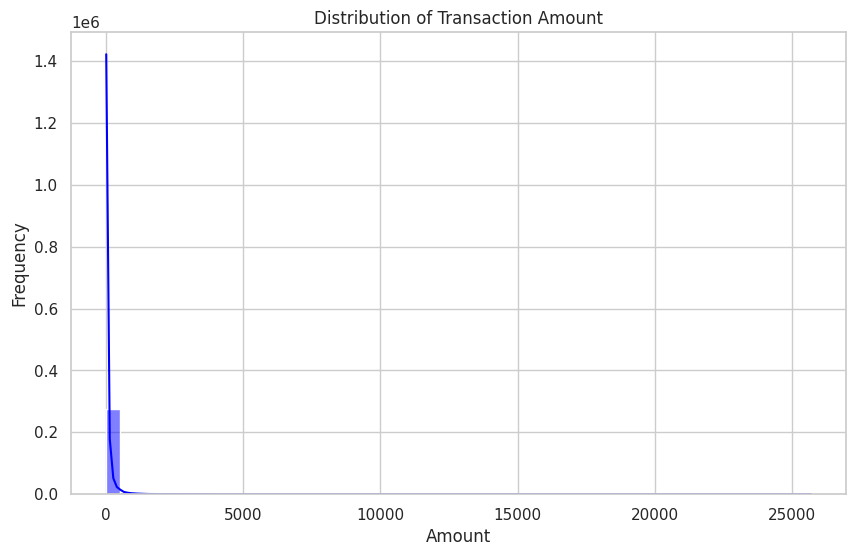

In [7]:
sns.set(style="whitegrid")

# Plot histogram of 'Amount'
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Amount'], kde=True, color='blue', bins=50)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

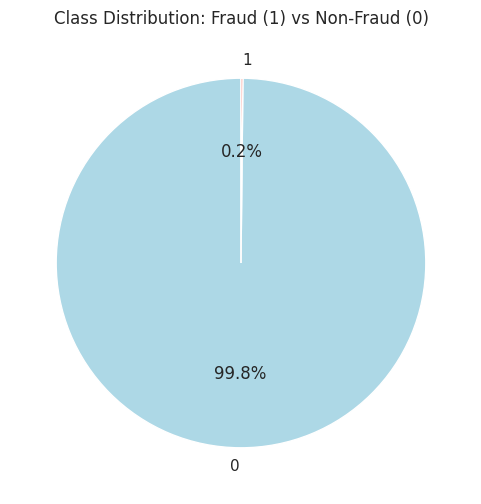

In [8]:
# Class distribution
class_distribution = df_cleaned['Class'].value_counts()

plt.figure(figsize=(6, 6))
class_distribution.plot.pie(autopct='%1.1f%%', colors=['lightblue', 'salmon'], startangle=90)
plt.title('Class Distribution: Fraud (1) vs Non-Fraud (0)')
plt.ylabel('')
plt.show()

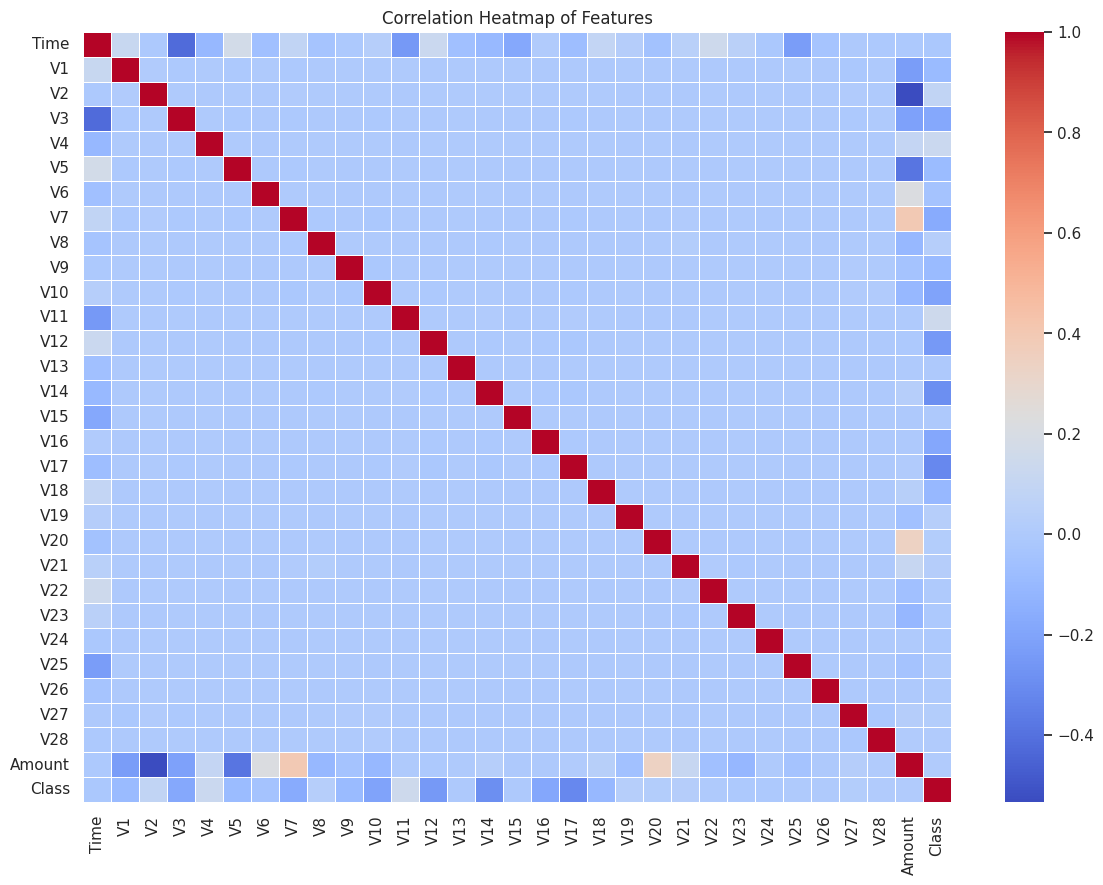

In [9]:
# Compute the correlation matrix
correlation_matrix = df_cleaned.corr()

# Plot heatmap of feature correlations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

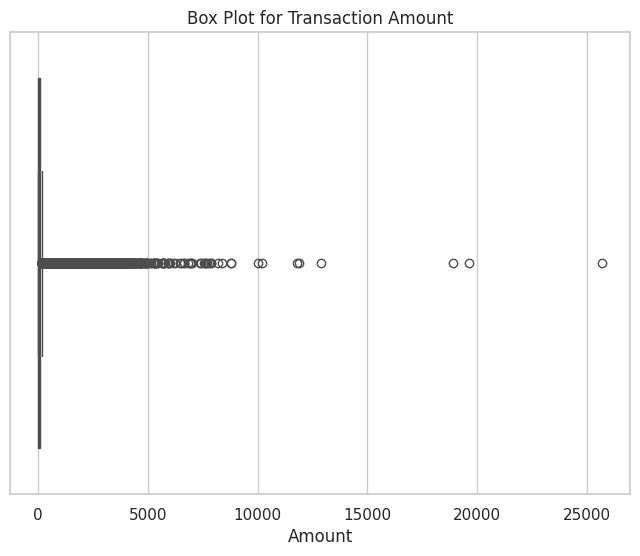

In [ ]:
# Plot box plot for 'Amount'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_cleaned['Amount'], color='orange')
plt.title('Box Plot for Transaction Amount')
plt.xlabel('Amount')
plt.show()

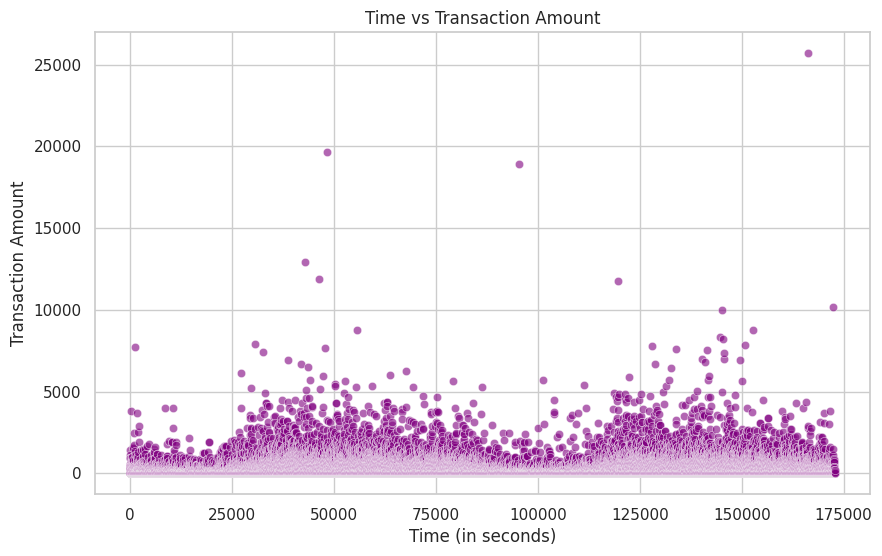

In [ ]:
# Scatter plot of 'Time' vs 'Amount'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_cleaned['Time'], y=df_cleaned['Amount'], color='purple', alpha=0.6)
plt.title('Time vs Transaction Amount')
plt.xlabel('Time (in seconds)')
plt.ylabel('Transaction Amount')
plt.show()

<ipython-input-18-a98e10607ead>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y='Time', data=df_cleaned, palette='muted')


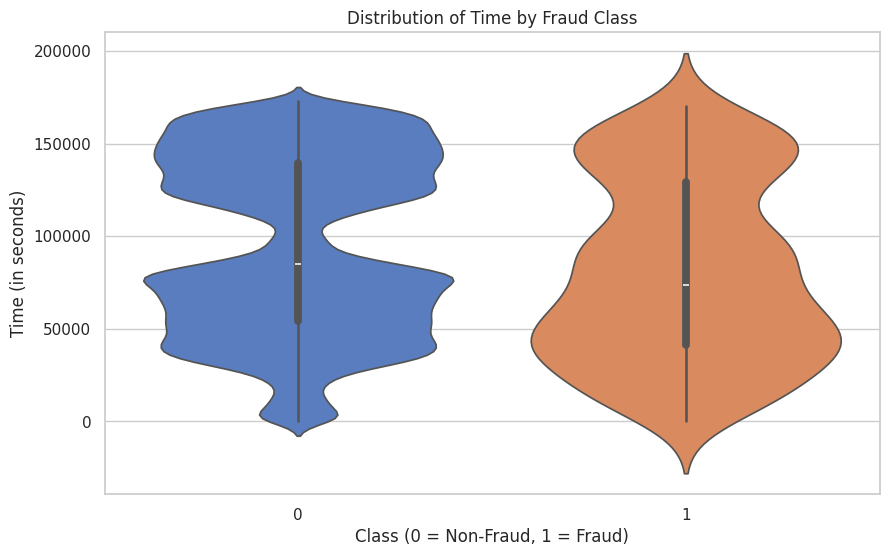

In [ ]:
# Violin plot of 'Time' distribution by 'Class'
plt.figure(figsize=(10, 6))
sns.violinplot(x='Class', y='Time', data=df_cleaned, palette='muted')
plt.title('Distribution of Time by Fraud Class')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Time (in seconds)')
plt.show()

<ipython-input-19-224f285ff2bb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=df_cleaned, palette='coolwarm')


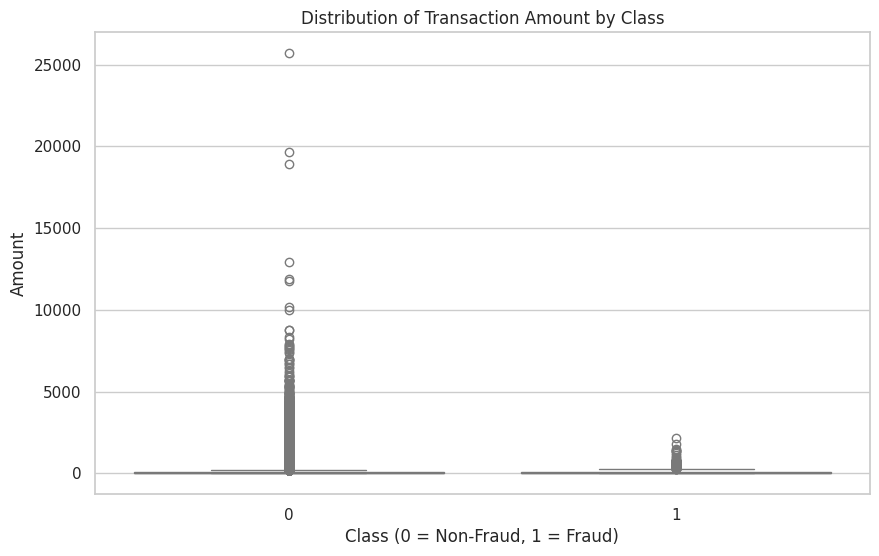

In [ ]:
# Box plot of 'Amount' distribution by 'Class'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df_cleaned, palette='coolwarm')
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Amount')
plt.show()

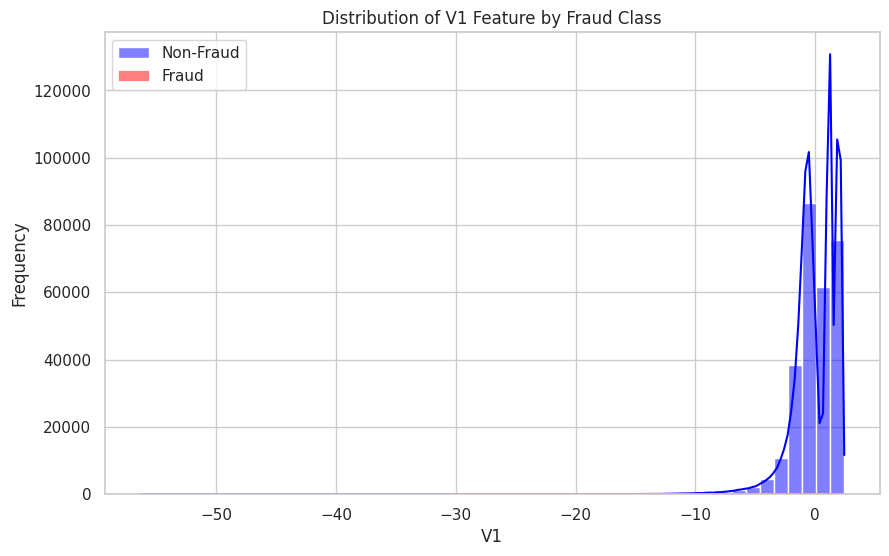

In [ ]:
# Histogram of 'V1' for both classes (Fraud and Non-Fraud)
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[df_cleaned['Class'] == 0]['V1'], color='blue', kde=True, label='Non-Fraud', bins=50)
sns.histplot(df_cleaned[df_cleaned['Class'] == 1]['V1'], color='red', kde=True, label='Fraud', bins=50)
plt.title('Distribution of V1 Feature by Fraud Class')
plt.xlabel('V1')
plt.ylabel('Frequency')
plt.legend()
plt.show()

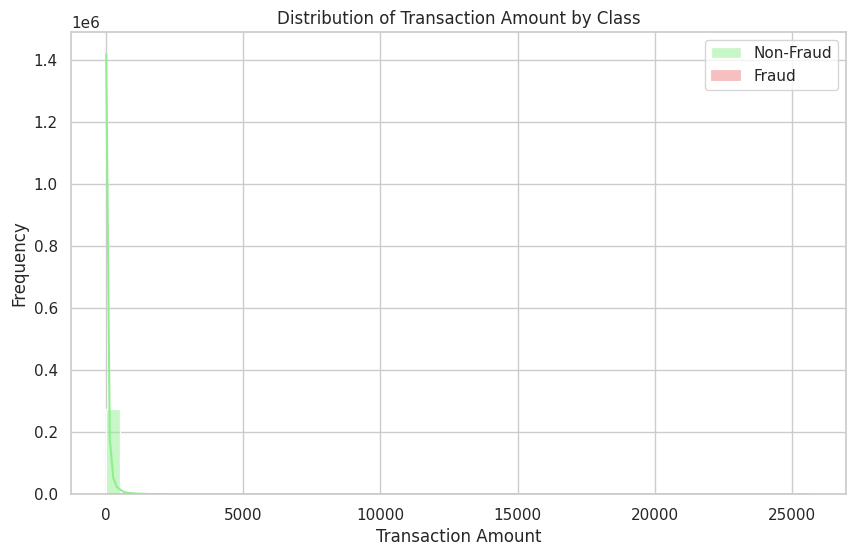

In [ ]:
# Histogram of 'Amount' for both classes (Fraud and Non-Fraud)
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[df_cleaned['Class'] == 0]['Amount'], color='lightgreen', kde=True, label='Non-Fraud', bins=50)
sns.histplot(df_cleaned[df_cleaned['Class'] == 1]['Amount'], color='lightcoral', kde=True, label='Fraud', bins=50)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**To address the class imbalance in the dataset, I applied SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class (fraudulent transactions) and balance the class distribution.**

# **Feature Importance**

In [27]:
# Separate features and target
X = df_cleaned.drop(columns=['Class'])
y = df_cleaned['Class']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SelectKBest (Chi-Square Test)
selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(abs(X_scaled), y)
selected_features = X.columns[selector.get_support()]
print("Top 10 selected features using SelectKBest:", list(selected_features))

Top 10 selected features using SelectKBest: ['V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


In [ ]:
# Feature Importance using RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_scaled, y)
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("\nTop features based on RandomForest Importance:\n", feature_importance_df.head(10))


Top features based on RandomForest Importance:
    Feature  Importance
17     V17    0.154219
14     V14    0.136456
12     V12    0.123372
10     V10    0.087651
16     V16    0.068716
11     V11    0.050253
9       V9    0.035881
18     V18    0.030688
7       V7    0.027981
4       V4    0.026054


In [28]:
selected_features = ['V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

# Create a new dataset with selected features
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_features]

# Check the new shape of the dataset
print("Shape of X_selected:", X_selected.shape)

Shape of X_selected: (283726, 8)


In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the selected features
selected_features = ['V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

# Create a new dataset with selected features
X_selected = X[selected_features]

# Scale only the selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)  # Now scaling only the selected features

# Create a new DataFrame with the scaled data, keeping the selected features as columns
X_selected_scaled = pd.DataFrame(X_scaled, columns=selected_features)

# Split data into train and test sets (80% train, 20% test) BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Apply SMOTE only to the training set (this helps address class imbalance in the training set)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now your data is safe for training and evaluation
print(f"Shape of X_train_resampled: {X_train_resampled.shape}")
print(f"Shape of y_train_resampled: {y_train_resampled.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_resampled: (453194, 8)
Shape of y_train_resampled: (453194,)
Shape of X_test: (56746, 8)
Shape of y_test: (56746,)


# **Decision Tree model**

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.28      0.74      0.41        90

    accuracy                           1.00     56746
   macro avg       0.64      0.87      0.70     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
 [[56486   170]
 [   23    67]]
Accuracy: 0.9965988792161562


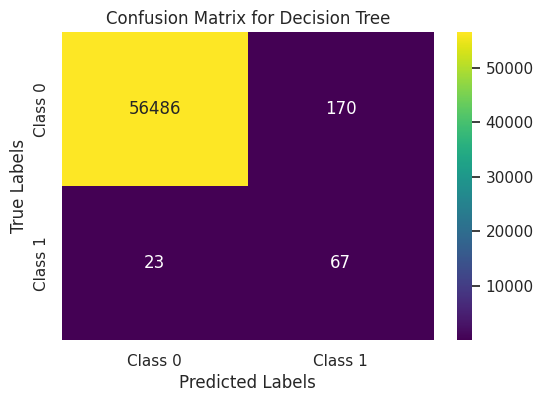

In [33]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Initialize the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the resampled training data
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot Confusion Matrix for Decision Tree
plot_confusion_matrix(y_test, y_pred, "Decision Tree")

# **cross-validation on Decision Tree Classifier**

# **XGBoost model**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:18:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.35      0.78      0.48        90

    accuracy                           1.00     56746
   macro avg       0.68      0.89      0.74     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
 [[56527   129]
 [   20    70]]
Accuracy: 0.9973742642653227


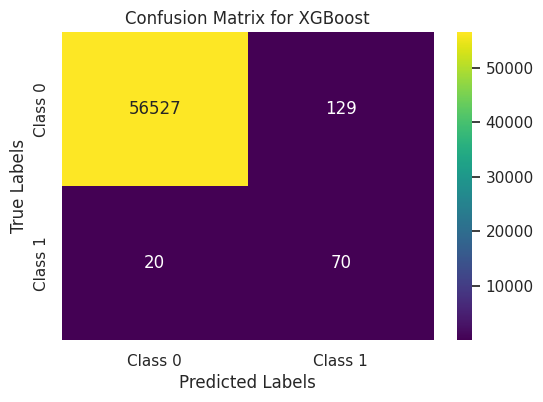

In [34]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Train the model on the resampled training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot Confusion Matrix for XGBoost
plot_confusion_matrix(y_test, y_pred, "XGBoost")

# **KNN classifier**

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.26      0.78      0.39        90

    accuracy                           1.00     56746
   macro avg       0.63      0.89      0.69     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
 [[56454   202]
 [   20    70]]
Accuracy: 0.9960878299792055


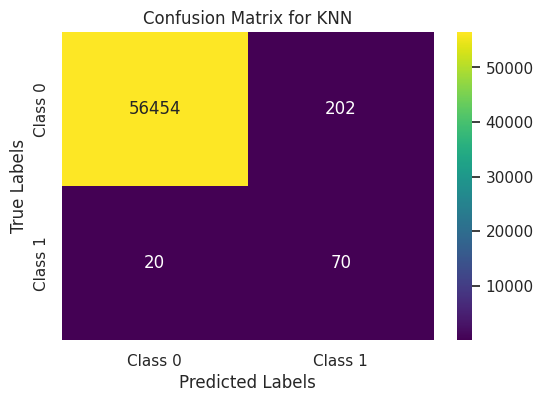

In [35]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Initialize the KNN classifier (choosing k=5 as default)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model on the resampled training data
knn_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot Confusion Matrix for KNN
plot_confusion_matrix(y_test, y_pred, "KNN")

## **Cross-validation**

In [17]:
from sklearn.model_selection import cross_val_score

# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Perform cross-validation
dt_scores = cross_val_score(dt_model, X_train, y_train, cv=5)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=5)

# Print results
print("Decision Tree CV Scores:", dt_scores)
print("Decision Tree Mean Accuracy:", dt_scores.mean())

print("\nXGBoost CV Scores:", xgb_scores)
print("XGBoost Mean Accuracy:", xgb_scores.mean())

print("\nKNN CV Scores:", knn_scores)
print("KNN Mean Accuracy:", knn_scores.mean())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:07:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Decision Tree CV Scores: [0.99914089 0.99907481 0.99933915 0.99920698 0.99905278]
Decision Tree Mean Accuracy: 0.9991629218433342

XGBoost CV Scores: [0.99949335 0.99920698 0.9995374  0.99951538 0.99933915]
XGBoost Mean Accuracy: 0.9994184509648427

KNN CV Scores: [0.99951538 0.99944929 0.99971363 0.99955943 0.99944929]
KNN Mean Accuracy: 0.9995374041765794


# **Saving the Models**

In [36]:
import joblib

# Save the Decision Tree model
joblib.dump(dt_model, '/content/dt_model.pkl')

# Save the XGBoost model
joblib.dump(xgb_model, '/content/xgb_model.pkl')

# Save the KNN model
joblib.dump(knn_model, '/content/knn_model.pkl')

print("Models saved successfully.")

Models saved successfully.


In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

# Save the scaler
joblib.dump(scaler, '/content/scaler.pkl')

['/content/scaler.pkl']

# **Real-Time Fraud Detection Prediction System with Model Selection**

In [38]:
import ipywidgets as widgets
from IPython.display import display

# Load the scaler and models
scaler = joblib.load('/content/scaler.pkl')
dt_model = joblib.load('/content/dt_model.pkl')
xgb_model = joblib.load('/content/xgb_model.pkl')
knn_model = joblib.load('/content/knn_model.pkl')

# Selected features used in the model
selected_features = ['V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

In [39]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Input style with better spacing
input_style = {'description_width': 'initial'}

# Create widgets for user input with updated layout and color scheme
V4_input = widgets.FloatText(value=0.0, description="V4:", style=input_style, layout=widgets.Layout(width='250px'))
V7_input = widgets.FloatText(value=0.0, description="V7:", style=input_style, layout=widgets.Layout(width='250px'))
V10_input = widgets.FloatText(value=0.0, description="V10:", style=input_style, layout=widgets.Layout(width='250px'))
V11_input = widgets.FloatText(value=0.0, description="V11:", style=input_style, layout=widgets.Layout(width='250px'))
V12_input = widgets.FloatText(value=0.0, description="V12:", style=input_style, layout=widgets.Layout(width='250px'))
V14_input = widgets.FloatText(value=0.0, description="V14:", style=input_style, layout=widgets.Layout(width='250px'))
V16_input = widgets.FloatText(value=0.0, description="V16:", style=input_style, layout=widgets.Layout(width='250px'))
V17_input = widgets.FloatText(value=0.0, description="V17:", style=input_style, layout=widgets.Layout(width='250px'))

model_choice_widget = widgets.Dropdown(
    options=['Decision Tree', 'XGBoost', 'KNN'],
    value='Decision Tree',
    description='Model:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='250px')
)

# Output widget to display predictions
output = widgets.Output()

# Function to display feedback with better message style
def show_feedback(msg):
    with output:
        print(f"<h4 style='color: #FF5722; font-family: Arial, sans-serif;'>{msg}</h4>")

# Function to predict and display results when button is clicked
def predict_model(V4, V7, V10, V11, V12, V14, V16, V17, model_choice):
    with output:
        # Create a dataframe from the input values
        input_data = pd.DataFrame({
            'V4': [V4],
            'V7': [V7],
            'V10': [V10],
            'V11': [V11],
            'V12': [V12],
            'V14': [V14],
            'V16': [V16],
            'V17': [V17]
        })

        # Ensure input_data is in the same feature order as the model training data
        input_data = input_data[selected_features]

        # Check if there are any zero values in the input data (excluding valid non-zero inputs)
        if (input_data == 0).any(axis=None):
            zero_inputs = input_data[input_data == 0].count()
            if zero_inputs.sum() == 8:
                show_feedback("⚠️ Warning: All inputs are set to zero. Please provide valid transaction values.")
                return

        # Scale the input data using the fitted scaler
        input_data_scaled = scaler.transform(input_data)

        # Choose the model based on user input
        if model_choice == 'Decision Tree':
            model = dt_model
        elif model_choice == 'XGBoost':
            model = xgb_model
        elif model_choice == 'KNN':
            model = knn_model

        # Make the prediction
        prediction = model.predict(input_data_scaled)

        # Display the prediction
        if prediction[0] == 1:
            show_feedback("🚨 Prediction: Fraudulent!")
        else:
            show_feedback("✅ Prediction: Non-fraudulent")

# Function to trigger prediction on button click
def on_button_click(b):
    # Get the values from the widgets
    V4 = V4_input.value
    V7 = V7_input.value
    V10 = V10_input.value
    V11 = V11_input.value
    V12 = V12_input.value
    V14 = V14_input.value
    V16 = V16_input.value
    V17 = V17_input.value
    model_choice = model_choice_widget.value

    # Call the prediction function
    predict_model(V4, V7, V10, V11, V12, V14, V16, V17, model_choice)

# Create a button for making the prediction with custom styling
predict_button = widgets.Button(description="Predict", button_style='success', layout=widgets.Layout(width='250px'))
predict_button.on_click(on_button_click)

# Create a heading with a bold and larger font size
heading = widgets.HTML(value="<h2 style='text-align:center; color:#FF5722; font-family:Arial, sans-serif;'>Fraud Detection Prediction</h2>")

# Customizing the layout of input fields
input_widgets = widgets.VBox([heading,
                              V4_input, V7_input, V10_input, V11_input, V12_input, V14_input, V16_input, V17_input,
                              model_choice_widget, predict_button],
                             layout=widgets.Layout(padding='10px', background_color='#F5F5F5', border='2px solid #FF5722'))

# Customizing the output area
output.layout.height = '150px'
output.layout.border = '2px solid #FF5722'
output.layout.padding = '10px'
output.layout.margin = '10px'
output.layout.background_color = '#f9f9f9'

# Display the input widgets and output area
display(input_widgets, output)

Output(layout=Layout(border='2px solid #FF5722', height='150px', margin='10px', padding='10px'))